# **Dataloading and Augmentation**

In [1]:
import torch

In [2]:
import torchvision
import torchvision.transforms as transforms

def data_load_aug(batch_size,num_workers):
    
    #data_augmentation for training data
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(p=0.7),
        transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    
    #data_augmetation for testing data
    transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
    
    #training data
    trainset = torchvision.datasets.CIFAR10(root = './data', download = True, train = True, transform = transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers=num_workers)

    #testing data
    testset = torchvision.datasets.CIFAR10(root = './data', download = True, train = False, transform = transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=num_workers)

    return trainloader,testloader

# **Models**

In [3]:
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torch.nn.functional as F

In [4]:
class ResBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1, option='A'):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if stride==1 and in_channels == out_channels:
            if option != 'C': 
                self.shortcut = nn.Sequential()
            else:
                self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            if option == 'A':
                self.shortcut = lambda x: F.pad(x[:,:,::2,::2], (0,0,0,0,(out_channels-in_channels)//2,(out_channels-in_channels)//2))
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
    
    def forward(self, x):
        x_short = x
        x = F.celu(self.bn1(self.conv1(x)),alpha=0.075) #celu activation func is used instead of relu
        x = self.bn2(self.conv2(x))
        x += self.shortcut(x_short) #short connections
        return F.celu(x,alpha= 0.075)

In [5]:
class BottleNeck(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride = 1, option='A'):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 1, padding=0, bias=False, stride=stride)
        self.bn3 = nn.BatchNorm2d(out_channels)

        if stride==1 and in_channels==out_channels:
            if option != 'C': 
                self.shortcut = nn.Sequential()
            else:
                self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            if option == 'A':
                self.shortcut = lambda x: F.pad(x[:,:,::2,::2], (0,0,0,0,(out_channels-in_channels)//2,(out_channels-in_channels)//2))
            else:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, stride = stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        x_short = x
        x = F.celu(self.bn1(self.conv1(x)),alpha = 0.075)
        x = F.celu(self.bn2(self.conv2(x)),alpha = 0.075)
        x = self.bn3(self.conv3(x))
        x += self.shortcut(x_short) #short connection
        x = F.celu(x,alpha = 0.075)
        return x

In [6]:
class ResNet(nn.Module):
    
    def __init__(self,block,filter_map,n,num_classes=10,option='A'):
        super().__init__()

        self.conv1  = nn.Conv2d(in_channels=3,out_channels=filter_map[0],kernel_size=3,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(filter_map[0])
        self.block1 = self.MakeResNetLayer(block,filter_map[0],n,stride=1,option=option) 
        #self.drop1  = nn.Dropout2d(0.3)
        self.block2 = self.MakeResNetLayer(block,(filter_map[0],filter_map[1]),n,stride=2,option=option)
        #self.drop2  = nn.Dropout2d(0.2)
        self.block3 = self.MakeResNetLayer(block,(filter_map[1],filter_map[2]),n,stride=2,option=option)
        self.drop3  = nn.Dropout2d(0.25)
        self.globalavgpool = nn.AdaptiveAvgPool2d(2)

        #self.drop1  = nn.Dropout(0.3)
        self.fc = nn.Linear(2*2*filter_map[2],num_classes)  

    def MakeResNetLayer(self,block,filters,n,stride,option='A'):

        if stride!=1 :
            in_planes,out_planes = filters
        else :
            in_planes,out_planes = filters,filters
        layer = []
        layer.append(block(in_planes,out_planes,stride, option=option))
        for i in range(n-1):
            layer.append(block(out_planes, out_planes, option=option))

        SubBlock = nn.Sequential(*layer)
        return SubBlock

    def forward(self,x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.globalavgpool(x)
        x = x.view(-1, self.find_shape(x))
        x = self.fc(x)
        return x

    def find_shape(self, x):
        res = 1
        for dim in x[0].shape:
            res *= dim
        return res

In [7]:
import os
import time
import importlib
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import time
from tqdm.notebook import tqdm

In [8]:
model_config = {'block_type': 'ResBlock', 'depth': 3, 'option': 'A'}
optim_config = {'epochs': 160, 'batch_size': 128,'base_lr': 0.1, 'weight_decay': 1e-4,
               'momentum': 0.9, 'milestones': '[80, 120]', 'lr_decay': 0.1}
run_config = {'num_workers': 2}

if model_config['block_type'] == 'ResBlock':
    
    model = ResNet(ResBlock,filter_map=[16,32,64],n=model_config['depth'],option=model_config['option'])
else :
    
    model = ResNet(BottleNeck,[16,32,64],model_config['depth'],model_config['option'])

optimizer = torch.optim.Adam(params=model.parameters(),lr = optim_config['base_lr'],weight_decay=optim_config['weight_decay'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=optim_config['milestones'],gamma=optim_config['lr_decay'])

# **Evaluation Metrics**

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix


def plot_accuracy_epoch(accuracy_train, accuracy_test):

    plt.figure(figsize=(12,7))
    plt.title("Train and Test Accuracy in ResNet")
    sns.lineplot(data = accuracy_train,label="Training accuracy",palette="muted")
    sns.lineplot(data = accuracy_test,label="Test Accuracy Model",palette="Dark")
    plt.xlabel("Epochs")    
    plt.ylabel("Accuracy")
    plt.savefig('accuracy.png')
    plt.show()
    return


def plot_loss_epoch(loss_train,loss_test):

    plt.figure(figsize=(12,7))
    plt.title("Train and Test Loss in ResNet")
    sns.lineplot(data = loss_train,label="Training Loss",palette="muted")
    sns.lineplot(data = loss_test,label="Test Loss",palette="dark")
    plt.xlabel("Epochs")    
    plt.ylabel("Loss")
    plt.show()
    plt.savefig('loss.png')
    return


def make_heat_map(model,test_loader,device='cpu') :

    with torch.no_grad():
        correct = 0
        for X_test, y_test in test_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_val = model(X_test)
            predicted = torch.max(y_val,1)[1]
            correct += (predicted == y_test).sum()
        
        print(f'Test accuracy Basic: {correct.item()}/{len(test_loader)*test_loader.batch_size} = {correct.item()*100/(len(test_loader)*test_loader.batch_size):7.3f}%')

    class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']    
    arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
    df_cm = pd.DataFrame(arr, class_names, class_names)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()
    plt.savefig('heatmap.png')
    return

# **Training**

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


epoch:0 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:0  loss:822.857 accuracy:27.70% test_accuracy:37.21%


epoch:1 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:1  loss:659.722 accuracy:37.86% test_accuracy:39.67%


epoch:2 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:2  loss:633.265 accuracy:40.28% test_accuracy:45.43%


epoch:3 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:3  loss:610.201 accuracy:42.70% test_accuracy:44.33%


epoch:4 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:4  loss:586.317 accuracy:45.07% test_accuracy:46.89%


epoch:5 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:5  loss:570.527 accuracy:47.03% test_accuracy:50.05%


epoch:6 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:6  loss:554.026 accuracy:48.97% test_accuracy:51.90%


epoch:7 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:7  loss:539.754 accuracy:50.84% test_accuracy:50.67%


epoch:8 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:8  loss:534.156 accuracy:51.21% test_accuracy:49.63%


epoch:9 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:9  loss:529.909 accuracy:51.61% test_accuracy:53.27%


epoch:10 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:10  loss:527.623 accuracy:51.78% test_accuracy:49.90%


epoch:11 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:11  loss:524.699 accuracy:52.22% test_accuracy:51.06%


epoch:12 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:12  loss:527.050 accuracy:52.30% test_accuracy:49.88%


epoch:13 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:13  loss:520.825 accuracy:52.78% test_accuracy:51.92%


epoch:14 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:14  loss:525.234 accuracy:52.57% test_accuracy:46.84%


epoch:15 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:15  loss:524.799 accuracy:52.30% test_accuracy:53.59%


epoch:16 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:16  loss:518.983 accuracy:52.87% test_accuracy:51.78%


epoch:17 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:17  loss:524.565 accuracy:52.40% test_accuracy:55.29%


epoch:18 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:18  loss:520.619 accuracy:52.58% test_accuracy:51.79%


epoch:19 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:19  loss:523.815 accuracy:52.28% test_accuracy:53.88%


epoch:20 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:20  loss:521.802 accuracy:52.69% test_accuracy:53.47%


epoch:21 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:21  loss:520.266 accuracy:53.17% test_accuracy:50.27%


epoch:22 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:22  loss:521.123 accuracy:52.55% test_accuracy:46.70%


epoch:23 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:23  loss:516.577 accuracy:53.23% test_accuracy:51.16%


epoch:24 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:24  loss:515.037 accuracy:53.45% test_accuracy:47.14%


epoch:25 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:25  loss:515.705 accuracy:53.10% test_accuracy:48.11%


epoch:26 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:26  loss:515.309 accuracy:53.16% test_accuracy:50.78%


epoch:27 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:27  loss:522.671 accuracy:52.53% test_accuracy:39.86%


epoch:28 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:28  loss:515.603 accuracy:53.47% test_accuracy:48.14%


epoch:29 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:29  loss:521.555 accuracy:52.64% test_accuracy:52.46%


epoch:30 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:30:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:30  loss:516.162 accuracy:52.88% test_accuracy:51.85%


epoch:31 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:31:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:31  loss:516.832 accuracy:53.00% test_accuracy:51.36%


epoch:32 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:32:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:32  loss:520.422 accuracy:52.98% test_accuracy:52.73%


epoch:33 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:33:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:33  loss:516.602 accuracy:53.20% test_accuracy:49.13%


epoch:34 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:34:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:34  loss:515.207 accuracy:53.18% test_accuracy:54.45%


epoch:35 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:35:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:35  loss:513.119 accuracy:53.41% test_accuracy:53.34%


epoch:36 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:36:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:36  loss:517.083 accuracy:52.97% test_accuracy:50.57%


epoch:37 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:37:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:37  loss:514.446 accuracy:53.47% test_accuracy:54.03%


epoch:38 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:38:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:38  loss:513.991 accuracy:53.16% test_accuracy:56.15%


epoch:39 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:39:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:39  loss:515.787 accuracy:52.96% test_accuracy:48.32%


epoch:40 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:40:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:40  loss:516.387 accuracy:53.21% test_accuracy:54.77%


epoch:41 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:41:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:41  loss:514.736 accuracy:53.20% test_accuracy:51.09%


epoch:42 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:42:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:42  loss:513.356 accuracy:53.46% test_accuracy:52.22%


epoch:43 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:43:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:43  loss:510.703 accuracy:53.54% test_accuracy:52.06%


epoch:44 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:44:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:44  loss:511.774 accuracy:53.35% test_accuracy:53.56%


epoch:45 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:45:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:45  loss:514.239 accuracy:53.27% test_accuracy:56.47%


epoch:46 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:46:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:46  loss:514.190 accuracy:53.51% test_accuracy:49.74%


epoch:47 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:47:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:47  loss:509.104 accuracy:53.96% test_accuracy:52.84%


epoch:48 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:48:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:48  loss:513.967 accuracy:53.22% test_accuracy:52.22%


epoch:49 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:49:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:49  loss:513.582 accuracy:53.32% test_accuracy:51.42%


epoch:50 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:50:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:50  loss:514.409 accuracy:53.07% test_accuracy:51.14%


epoch:51 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:51:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:51  loss:514.912 accuracy:52.92% test_accuracy:49.69%


epoch:52 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:52:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:52  loss:515.134 accuracy:53.16% test_accuracy:51.50%


epoch:53 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:53:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:53  loss:511.347 accuracy:53.61% test_accuracy:51.86%


epoch:54 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:54:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:54  loss:514.423 accuracy:53.35% test_accuracy:49.85%


epoch:55 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:55:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:55  loss:511.056 accuracy:53.73% test_accuracy:53.40%


epoch:56 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:56:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:56  loss:513.452 accuracy:53.38% test_accuracy:53.83%


epoch:57 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:57:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:57  loss:513.546 accuracy:53.28% test_accuracy:51.92%


epoch:58 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:58:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:58  loss:509.013 accuracy:53.73% test_accuracy:53.85%


epoch:59 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:59:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:59  loss:511.706 accuracy:53.37% test_accuracy:48.04%


epoch:60 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:60:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:60  loss:516.660 accuracy:53.13% test_accuracy:51.47%


epoch:61 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:61:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:61  loss:516.339 accuracy:53.30% test_accuracy:52.80%


epoch:62 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:62:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:62  loss:512.934 accuracy:53.24% test_accuracy:52.48%


epoch:63 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:63:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:63  loss:512.547 accuracy:53.50% test_accuracy:52.91%


epoch:64 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:64:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:64  loss:509.438 accuracy:53.65% test_accuracy:51.91%


epoch:65 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:65:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:65  loss:511.849 accuracy:53.44% test_accuracy:51.09%


epoch:66 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:66:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:66  loss:514.782 accuracy:53.18% test_accuracy:51.51%


epoch:67 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:67:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:67  loss:517.520 accuracy:52.93% test_accuracy:53.09%


epoch:68 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:68:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:68  loss:510.934 accuracy:53.54% test_accuracy:51.92%


epoch:69 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:69:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:69  loss:513.111 accuracy:53.50% test_accuracy:51.75%


epoch:70 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:70:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:70  loss:508.669 accuracy:53.66% test_accuracy:49.26%


epoch:71 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:71:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:71  loss:511.725 accuracy:53.39% test_accuracy:50.35%


epoch:72 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:72:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:72  loss:515.564 accuracy:53.03% test_accuracy:53.92%


epoch:73 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:73:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:73  loss:515.168 accuracy:53.55% test_accuracy:54.34%


epoch:74 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:74:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:74  loss:506.928 accuracy:54.18% test_accuracy:46.82%


epoch:75 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:75:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:75  loss:516.275 accuracy:52.97% test_accuracy:53.71%


epoch:76 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:76:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:76  loss:510.442 accuracy:53.60% test_accuracy:51.29%


epoch:77 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:77:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:77  loss:508.679 accuracy:53.61% test_accuracy:47.87%


epoch:78 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:78:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:78  loss:512.790 accuracy:53.44% test_accuracy:50.58%


epoch:79 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:79:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:79  loss:514.841 accuracy:53.35% test_accuracy:52.10%


epoch:80 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:80:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:80  loss:522.820 accuracy:52.65% test_accuracy:48.36%


epoch:81 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:81:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:81  loss:516.125 accuracy:53.21% test_accuracy:54.59%


epoch:82 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:82:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:82  loss:510.265 accuracy:53.53% test_accuracy:54.87%


epoch:83 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:83:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:83  loss:509.328 accuracy:53.92% test_accuracy:53.56%


epoch:84 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:84:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:84  loss:512.192 accuracy:53.43% test_accuracy:52.17%


epoch:85 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:85:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:85  loss:506.904 accuracy:53.60% test_accuracy:51.10%


epoch:86 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:86:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:86  loss:510.160 accuracy:53.53% test_accuracy:46.57%


epoch:87 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:87:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:87  loss:508.780 accuracy:53.85% test_accuracy:55.20%


epoch:88 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:88:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:88  loss:507.230 accuracy:53.84% test_accuracy:47.95%


epoch:89 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:89:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:89  loss:519.218 accuracy:52.97% test_accuracy:49.74%


epoch:90 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:90:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:90  loss:512.504 accuracy:53.44% test_accuracy:48.23%


epoch:91 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:91:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:91  loss:511.639 accuracy:53.54% test_accuracy:53.44%


epoch:92 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:92:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:92  loss:514.833 accuracy:52.90% test_accuracy:53.26%


epoch:93 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:93:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:93  loss:515.750 accuracy:53.08% test_accuracy:49.06%


epoch:94 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:94:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:94  loss:511.868 accuracy:53.21% test_accuracy:53.12%


epoch:95 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:95:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:95  loss:515.711 accuracy:53.33% test_accuracy:52.39%


epoch:96 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:96:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:96  loss:508.658 accuracy:53.96% test_accuracy:51.12%


epoch:97 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:97:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:97  loss:512.141 accuracy:53.63% test_accuracy:47.01%


epoch:98 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:98:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:98  loss:509.416 accuracy:53.80% test_accuracy:52.76%


epoch:99 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:99:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:99  loss:507.231 accuracy:54.11% test_accuracy:50.29%


epoch:100 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:100:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:100  loss:509.056 accuracy:53.82% test_accuracy:53.05%


epoch:101 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:101:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:101  loss:509.443 accuracy:53.58% test_accuracy:50.21%


epoch:102 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:102:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:102  loss:509.708 accuracy:53.67% test_accuracy:50.06%


epoch:103 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:103:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:103  loss:512.813 accuracy:53.31% test_accuracy:51.65%


epoch:104 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:104:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:104  loss:511.705 accuracy:53.42% test_accuracy:50.85%


epoch:105 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:105:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:105  loss:511.364 accuracy:53.40% test_accuracy:54.04%


epoch:106 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:106:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:106  loss:510.634 accuracy:53.51% test_accuracy:55.69%


epoch:107 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:107:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:107  loss:506.987 accuracy:53.69% test_accuracy:51.24%


epoch:108 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:108:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:108  loss:508.998 accuracy:53.89% test_accuracy:46.90%


epoch:109 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:109:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:109  loss:512.637 accuracy:53.54% test_accuracy:51.09%


epoch:110 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:110:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:110  loss:511.057 accuracy:53.47% test_accuracy:51.55%


epoch:111 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:111:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:111  loss:507.052 accuracy:53.92% test_accuracy:50.70%


epoch:112 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:112:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:112  loss:508.553 accuracy:53.74% test_accuracy:52.16%


epoch:113 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:113:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:113  loss:510.453 accuracy:53.45% test_accuracy:54.13%


epoch:114 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:114:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:114  loss:506.635 accuracy:53.82% test_accuracy:50.45%


epoch:115 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:115:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:115  loss:511.731 accuracy:53.45% test_accuracy:49.33%


epoch:116 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:116:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:116  loss:509.775 accuracy:53.59% test_accuracy:51.14%


epoch:117 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:117:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:117  loss:510.346 accuracy:53.71% test_accuracy:51.91%


epoch:118 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:118:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:118  loss:508.656 accuracy:53.89% test_accuracy:51.46%


epoch:119 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:119:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:119  loss:518.063 accuracy:52.96% test_accuracy:49.13%


epoch:120 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:120:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:120  loss:510.057 accuracy:53.64% test_accuracy:48.01%


epoch:121 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:121:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:121  loss:513.336 accuracy:53.40% test_accuracy:48.37%


epoch:122 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:122:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:122  loss:512.432 accuracy:53.26% test_accuracy:50.87%


epoch:123 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:123:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:123  loss:516.617 accuracy:53.09% test_accuracy:49.98%


epoch:124 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:124:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:124  loss:511.810 accuracy:53.50% test_accuracy:50.64%


epoch:125 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:125:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:125  loss:508.989 accuracy:54.08% test_accuracy:50.02%


epoch:126 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:126:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:126  loss:510.186 accuracy:53.43% test_accuracy:50.59%


epoch:127 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:127:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:127  loss:512.322 accuracy:53.31% test_accuracy:47.48%


epoch:128 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:128:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:128  loss:507.961 accuracy:53.57% test_accuracy:50.49%


epoch:129 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:129:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:129  loss:513.977 accuracy:53.34% test_accuracy:51.33%


epoch:130 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:130:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:130  loss:510.013 accuracy:53.66% test_accuracy:46.42%


epoch:131 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:131:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:131  loss:513.732 accuracy:53.48% test_accuracy:51.68%


epoch:132 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:132:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:132  loss:510.970 accuracy:53.83% test_accuracy:49.96%


epoch:133 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:133:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:133  loss:505.940 accuracy:53.97% test_accuracy:48.16%


epoch:134 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:134:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:134  loss:510.617 accuracy:53.64% test_accuracy:50.75%


epoch:135 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:135:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:135  loss:510.214 accuracy:53.45% test_accuracy:52.22%


epoch:136 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:136:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:136  loss:510.452 accuracy:53.47% test_accuracy:53.26%


epoch:137 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:137:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:137  loss:509.354 accuracy:53.72% test_accuracy:45.04%


epoch:138 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:138:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:138  loss:513.441 accuracy:53.37% test_accuracy:49.17%


epoch:139 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:139:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:139  loss:509.704 accuracy:53.53% test_accuracy:54.85%


epoch:140 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:140:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:140  loss:510.187 accuracy:53.51% test_accuracy:49.12%


epoch:141 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:141:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:141  loss:507.009 accuracy:53.99% test_accuracy:52.23%


epoch:142 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:142:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:142  loss:509.768 accuracy:53.53% test_accuracy:51.74%


epoch:143 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:143:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:143  loss:515.153 accuracy:53.31% test_accuracy:49.56%


epoch:144 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:144:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:144  loss:511.918 accuracy:53.47% test_accuracy:53.80%


epoch:145 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:145:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:145  loss:512.467 accuracy:53.36% test_accuracy:52.65%


epoch:146 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:146:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:146  loss:507.643 accuracy:53.74% test_accuracy:52.14%


epoch:147 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:147:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:147  loss:511.623 accuracy:53.48% test_accuracy:53.70%


epoch:148 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:148:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:148  loss:515.740 accuracy:52.87% test_accuracy:50.19%


epoch:149 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:149:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:149  loss:512.634 accuracy:53.22% test_accuracy:52.37%


epoch:150 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:150:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:150  loss:515.609 accuracy:53.38% test_accuracy:55.72%


epoch:151 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:151:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:151  loss:516.430 accuracy:53.20% test_accuracy:40.10%


epoch:152 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:152:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:152  loss:523.000 accuracy:52.42% test_accuracy:50.26%


epoch:153 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:153:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:153  loss:514.772 accuracy:53.26% test_accuracy:51.83%


epoch:154 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:154:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:154  loss:515.382 accuracy:53.26% test_accuracy:55.02%


epoch:155 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:155:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:155  loss:510.676 accuracy:53.60% test_accuracy:52.85%


epoch:156 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:156:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:156  loss:512.103 accuracy:53.26% test_accuracy:52.27%


epoch:157 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:157:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:157  loss:516.596 accuracy:53.17% test_accuracy:51.35%


epoch:158 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:158:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:158  loss:515.850 accuracy:53.12% test_accuracy:52.18%


epoch:159 loss:0.0000 accuracy:NA:   0%|          | 0/391 [00:00<?, ?it/s]

[Validation] Epoch:159:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:159  loss:508.927 accuracy:53.85% test_accuracy:54.62%

Duration: 77.7829460978508 minutes


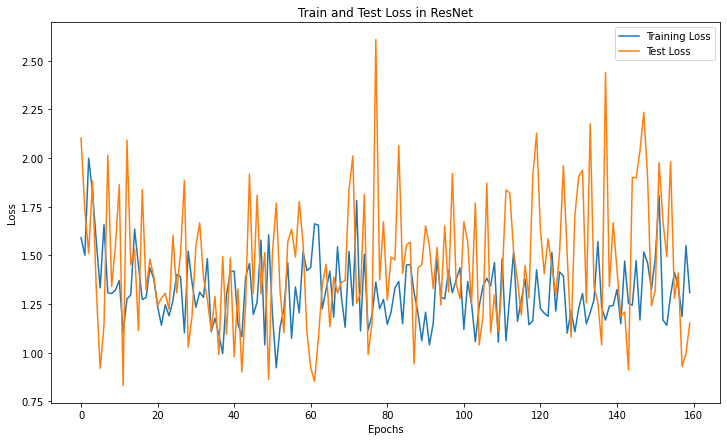

<Figure size 432x288 with 0 Axes>

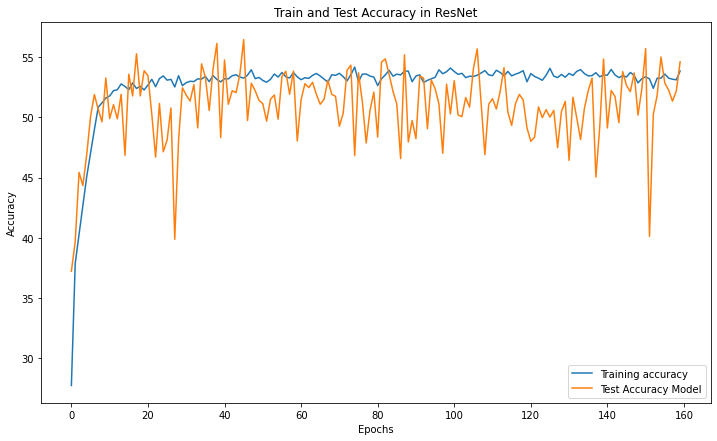

Files already downloaded and verified
Files already downloaded and verified
Test accuracy Basic: 5487/10000 =  54.870%


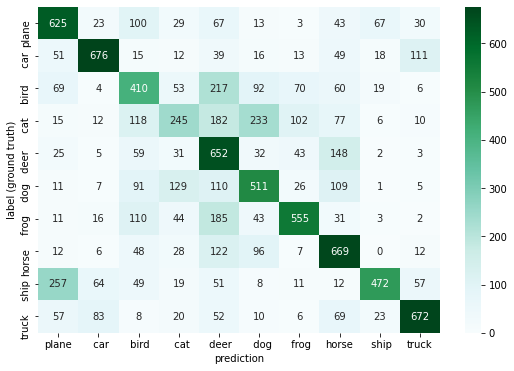

<Figure size 432x288 with 0 Axes>

In [10]:
def train(model,epochs,trainloader,testloader,device,criterion,optimizer,scheduler):

    model.train()
    start_time = time.time()
    train_losses = np.array([])
    test_losses = np.array([])
    train_correct = np.array([])
    test_correct = np.array([])

    for epoch in range(epochs):
        trn_corr = 0
        tst_corr = 0
        running_loss = 0
    
        # Run the training batches
        t = tqdm(trainloader, desc='epoch:{} loss:{:.4f} accuracy:{}'.format(epoch, 0.0, 'NA'), leave=True)
        for b, (X_train, y_train) in enumerate(t):
        
            # Apply the model
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            running_loss+=loss.item()
            
            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr.item()
        
            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        
            # # Print interim results
            if b%50 == 0:
                t.set_description('epoch:{} loss:{:.4f} accuracy:{}'.format(epoch, loss.item(), batch_corr.item()))
                t.refresh()

        
        train_losses = np.append(train_losses,loss.item())
        train_correct = np.append(train_correct,trn_corr/500)
    
        
        # Run the testing batches
        with torch.no_grad():
            t = tqdm(testloader, desc="[Validation] Epoch:{}".format(epoch), leave=True)
            for (X_test, y_test) in t:
          
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                
                # Apply the model
                y_val = model(X_test)

                # Tally the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1] 
                batch_corr = (predicted == y_test).sum()  
                tst_corr+=batch_corr.item()
 
        loss = criterion(y_val, y_test)
        print('Epoch:{}  loss:{:.3f} accuracy:{:.2f}% test_accuracy:{:.2f}%'.format(epoch, running_loss, trn_corr/500, tst_corr/100))

        test_losses=np.append(test_losses,loss.item())
        test_correct=np.append(test_correct,tst_corr/100)
        
    print(f'\nDuration: {(time.time() - start_time)/60} minutes') # print the time elapsed  ,minutes') # print the time elapsed
    
    return train_losses,test_losses,train_correct,test_correct

device = torch.device('cuda') #if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion = nn.CrossEntropyLoss()
train_loader,test_loader = data_load_aug(optim_config['batch_size'],run_config['num_workers'])

train_loss,test_loss,train_accuracy,test_accuracy = train(model,optim_config['epochs'],train_loader,test_loader,device,criterion,optimizer,scheduler)

plot_loss_epoch(train_loss,test_loss)
plot_accuracy_epoch(train_accuracy,test_accuracy)
_,test_checker = data_load_aug(10000,run_config['num_workers'])

make_heat_map(model,test_checker,device)

In [11]:
print(os.listdir('../working'))

['accuracy.png', '__notebook__.ipynb', 'heatmap.png', 'data', 'loss.png']
